In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

compas = pd.read_csv('cox-violent-parsed.csv')
adult = pd.read_csv('adult_with_pii.csv')

In [36]:
compas # id column only increments up to 11001 (technically the 11000th row, starting at 0)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,NaN,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,...,Risk of Violence,4,Low,29/12/2014,28/12/2014,07/01/2015,5,9,459,0
18312,NaN,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,...,Risk of Violence,1,Low,14/01/2014,13/01/2014,14/01/2014,0,0,808,0
18313,NaN,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,...,Risk of Violence,2,Low,09/03/2014,08/03/2014,09/03/2014,3,0,754,0
18314,NaN,florencia sanmartin,florencia,sanmartin,30/06/2014,Female,18/12/1992,23,Less than 25,Hispanic,...,Risk of Violence,4,Low,30/06/2014,15/03/2015,15/03/2015,2,0,258,0


In [37]:
compas[compas['id'] == 11001]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
11000,11001.0,david picard,david,picard,30/09/2013,Male,19/03/1987,29,25 - 45,Caucasian,...,Risk of Violence,6,Medium,30/09/2013,12/06/2014,15/07/2014,1,251,255,0


In [38]:
compas[compas['id'] == 11002]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event


In [3]:
# this code adds id values for all of the data rows past row 11000

for i in range(11001, len(compas)):
    compas.iloc[i, 0] = i+1

### Synthetic Representation

First, let's examine the COMPAS dataset without any noise to establish a baseline:

In [4]:
compas.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

(array([  23., 2923., 2031., 1813., 1830., 1649., 1713., 1720., 1614.,
        3000.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

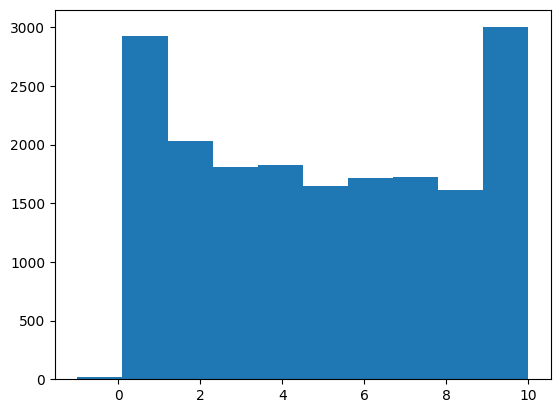

In [5]:
plt.hist(compas['decile_score'], bins=10)

# Alternative DP Definitions
The cells below compare the accuracy results of the following differentially private algorithms across the adult and COMPAS datasets.

## Renyi-Differential Privacy

### Summation

In [7]:
# Renyi-Differential Privacy Algorithm
# credit to Joe Near for python implementation
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

In [ ]:
def 

In [ ]:
# Adult Dataset (AGE)

# COMPAS Dataset (AGE)

# COMPAS Dataset (Decile Score)